In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
#! pip install opencv-python



Thanks for: https://baotramduong.medium.com/image-preprocessing-for-computer-vision-tasks-in-python-using-opencv-and-tensorflow-be5ddbeb6c09


In [2]:
import os
from pathlib import Path
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping
import cv2
from tensorflow.keras.applications.vgg16 import VGG16


SEED = 999
np.random.seed(SEED)

def load_paths():
  
    base_path = Path('/kaggle/input/last-alldata/dataset')
    images_pattern = str(base_path / '*' / '*.jpg')
    image_paths = [*glob(images_pattern)]
    image_paths = [p for p in image_paths]
    classes = {"Umm Qais", "Jeresh", "Petra", "Ajloun Castle", "Wadi_Rum", "Roman amphitheater"}
    return image_paths, classes
###########################
def apply_gaussian_blur(image, kernel_size=(5, 5)):
    return cv2.GaussianBlur(image, kernel_size, 0)
def equalize_histogram(image):
    return cv2.equalizeHist(image)
def apply_median_blur(image, kernel_size=5):
    return cv2.medianBlur(image, kernel_size)
############################

def load_images_and_labels(image_paths, target_size=(224, 224)):
    """
    Load images and corresponding labels from file paths.

    Args:
        image_paths (list): List of file paths.
        target_size (tuple): Target size for resizing images.

    Returns:
        Tuple: A tuple containing numpy arrays of images and labels.
    """
    images = []
    labels = []
    for image_path in image_paths:
        image = load_img(image_path, target_size=target_size)
        image = img_to_array(image)
        label = image_path.split(os.path.sep)[-2]
        images.append(image)
        labels.append(label)
    return np.array(images), np.array(labels)


#####################
def preprocess_data(X, y):
    #Preprocess the image
    
    X = X.astype('float') / 255.0
   # X = cv2.cvtColor(X, cv2.COLOR_BGR2HSV)
    #image = cv2.equalizeHist(X)
    
    y = LabelBinarizer().fit_transform(y)
    return X, y

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def build_model(input_shape=(224,224, 3), num_classes=6):
    """
    Build an InceptionV3 model for image classification.

    Args:
        input_shape (tuple): Input shape of images.
        num_classes (int): Number of output classes.

    Returns:
        Sequential: Compiled Keras model.
    """
    base_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    
    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, X_train, y_train, X_val, y_val, epochs=40, batch_size=64, early_stopping_patience=10):
    """
    Train the model on the given data.

    Args:
        model (Sequential): Compiled Keras model.
        X_train (numpy array): Training set images.
        y_train (numpy array): Training set labels.
        X_val (numpy array): Validation set images.
        y_val (numpy array): Validation set labels.
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training.
        early_stopping_patience (int): Patience for early stopping.

    Returns:
        Tuple: A tuple containing the trained model and training history.
    """
    early_stopping = EarlyStopping(monitor='val_loss', patience=early_stopping_patience, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early_stopping])
    return model, history

def evaluate_model(model, X_test, y_test):
    """
    Evaluate the model on the test set and print the test accuracy.

    Args:
        model (Sequential): Trained Keras model.
        X_test (numpy array): Test set images.
        y_test (numpy array): Test set labels.
    """
    result = model.evaluate(X_test, y_test)
    print(f'Test accuracy: {result[1]}')


def save_model(model, save_path='/kaggle/working/vgg16.h5'):
  
    model.save(save_path)
    # print(f"Model weights saved to {save_path}")

def plot_history(history, save_path=None):
  
    print(history.history.keys())
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('vgg16Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    if save_path:
        plt.savefig(save_path + '_accuracy.png')
    else:
        plt.show()

    plt.figure()
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title( 'vgg16 Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    if save_path:
        plt.savefig(save_path + '_loss.png')
    else:
        plt.show()

4452 1113
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/40
70/70 [==============================] - 50s 531ms/step - loss: 3.2715 - accuracy: 0.5211 - val_loss: 0.6274 - val_accuracy: 0.7718
Epoch 2/40
70/70 [==============================] - 26s 377ms/step - loss: 0.6444 - accuracy: 0.7635 - val_loss: 0.4660 - val_accuracy: 0.8347
Epoch 3/40
70/70 [==============================] - 28s 401ms/step - loss: 0.5050 - accuracy: 0.8124 - val_loss: 0.4968 - val_accuracy: 0.8221
Epoch 4/40
70/70 [==============================] - 29s 422ms/step - loss: 0.4683 - accuracy: 0.8275 - val_loss: 0.4319 - val_accuracy: 0.8607
Epoch 5/40
70/70 [==============================] - 28s 395ms/step - loss: 0.4148 - accuracy: 0.8468 - val_loss: 0.4821 - val_accuracy: 0.8401
Epoch 6/40
70/70 [==============================] - 29s 409ms/step - loss: 0.3568 - accuracy: 0.8702 - val_loss: 0.4266 - val_accuracy: 0.8652
Epoch 7/40
70/70 [==============================] - 28s 405ms/step 

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


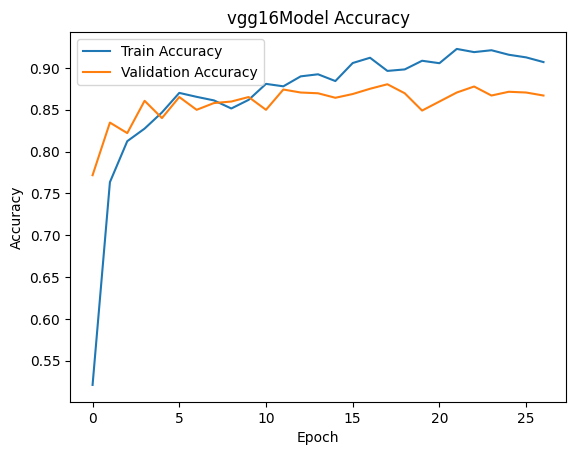

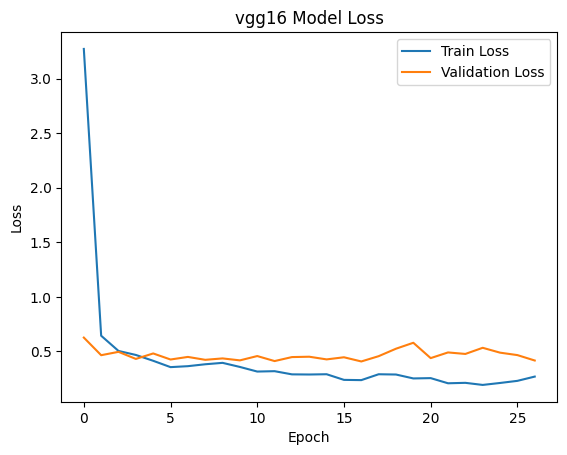

In [4]:
def main():
   
    image_paths, classes = load_paths()
    # print(len(image_paths), classes)

    X, y = load_images_and_labels(image_paths)
    X, y = preprocess_data(X, y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
    print( len(X_train), len(X_test))
    model = build_model()
    trained_model, history = train_model(model, X_train, y_train, X_test, y_test)

    evaluate_model(trained_model, X_test, y_test)
    plot_history(history, save_path='/kaggle/working/')

    # Save the model 
    save_model(trained_model)
#main()
if __name__ == "__main__":
    main()